In [13]:
import numpy as np
import pandas as pd
import os
import h5py
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from keras.wrappers.scikit_learn import KerasClassifier
from src.data import Galaxies
import src.CNNs as CNNs
from matplotlib import cm
from textwrap import wrap

In [2]:
plt.rcParams.update({'font.size': 16})

# Load and Explore the Data

In [3]:
# Load Data
data = Galaxies('data/Galaxy10_DECals.h5')
images, labels = data.load_data()

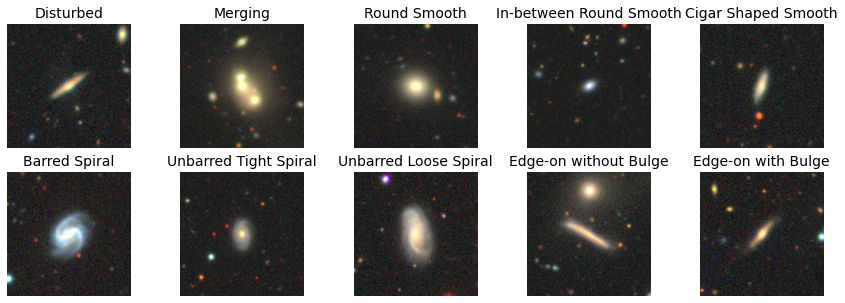

In [4]:
data.plot_few(rand=True) # Display a random image from each class

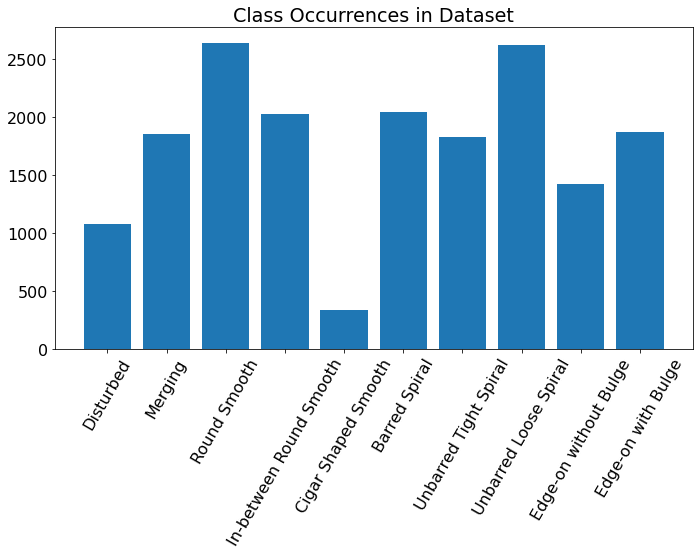

In [5]:
fig, ax = plt.subplots(figsize=(10,8))
data.count_classes(labels,ax)
#plt.savefig('imgs/class_occurrences.png')

# Split data into Train and Test Sets

In [6]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, stratify=labels, random_state=4)

# Convolutional Neural Network

In [8]:
# Prepare data for neural network ingest
train_images, test_images = data.prep_data(X_train,[128,128]), data.prep_data(X_test,[128,128])  #Downsample images by half and crop center
lg_train_images, lg_test_images = data.prep_data(X_train,[128,128], (20,108)), data.prep_data(X_test,[128,128],(20,108))  #Downsample images by half and crop

In [9]:
loaded_model = keras.models.load_model('saved_models/CNN5_aug_3x3_00drop_88in_50epochs20210809.h5')
loaded_model.evaluate(lg_test_images, y_test)

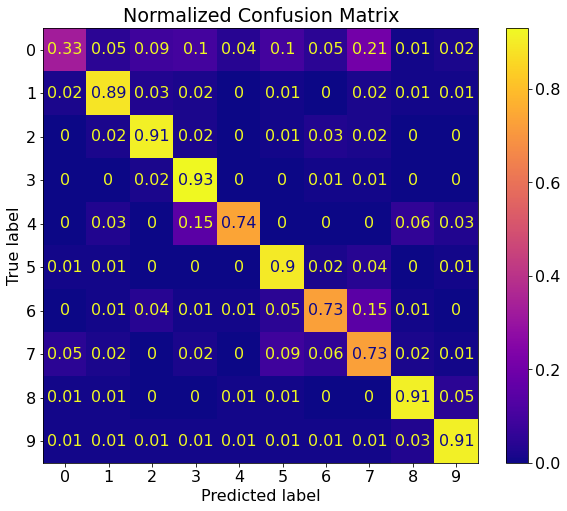

In [15]:
CNNs.plot_cm(y_test, loaded_model.predict_classes(lg_test_images))
#plt.savefig('imgs/confusion_matrix')

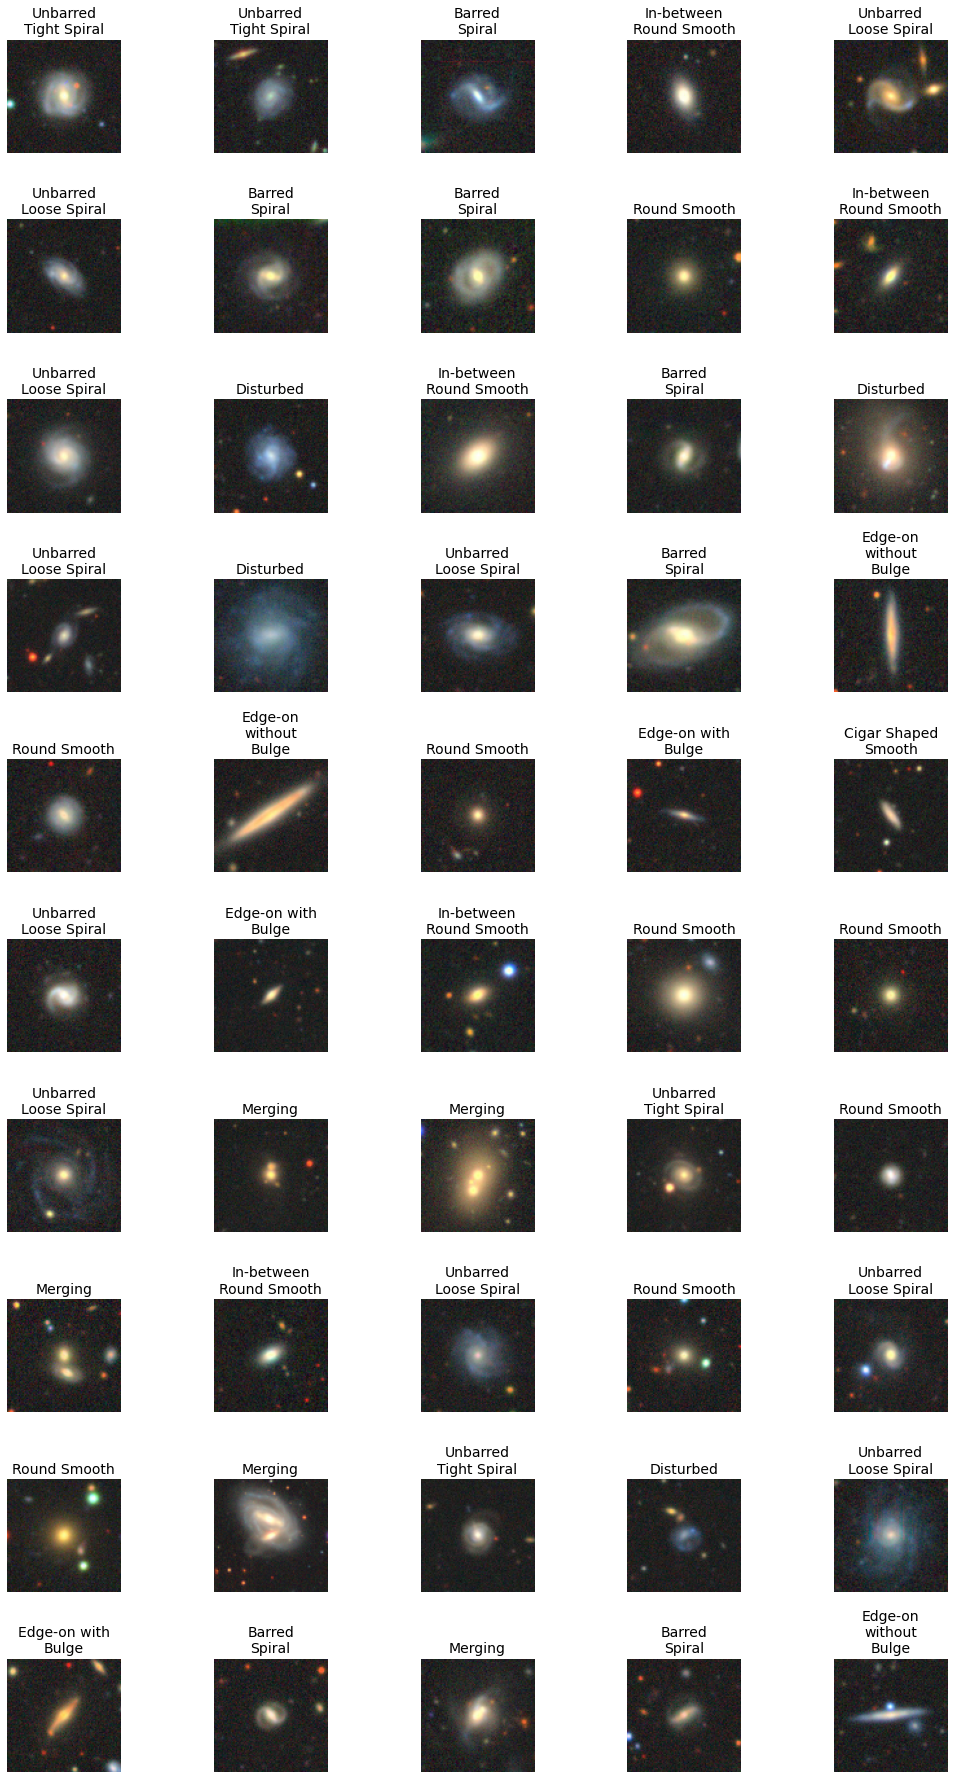

In [154]:
# Plot several images from the training set
fig, axs = plt.subplots(10,5, figsize=(15,25), sharex=True, sharey=True)

for idx, plot in enumerate(axs.flatten()):
    plot.imshow(train_images[idx])
    plot.set_title('\n'.join(wrap(data.class_dict[train_labels[idx]],12)),fontsize=14)
    plot.axis('off')
plt.tight_layout()

In [301]:
# Save the model
from datetime import datetime
saved_model_path = "./saved_models/CNN5_aug_50epochs_64in{}.h5".format(datetime.now().strftime("%Y%m%d"))
CNN.save(saved_model_path)

## Examine misclassifications

In [144]:
miss_mask = ~(y_pred == test_labels)
misses, missed_pred, missed_actual = test_images[miss_mask], y_pred[miss_mask], test_labels[miss_mask]


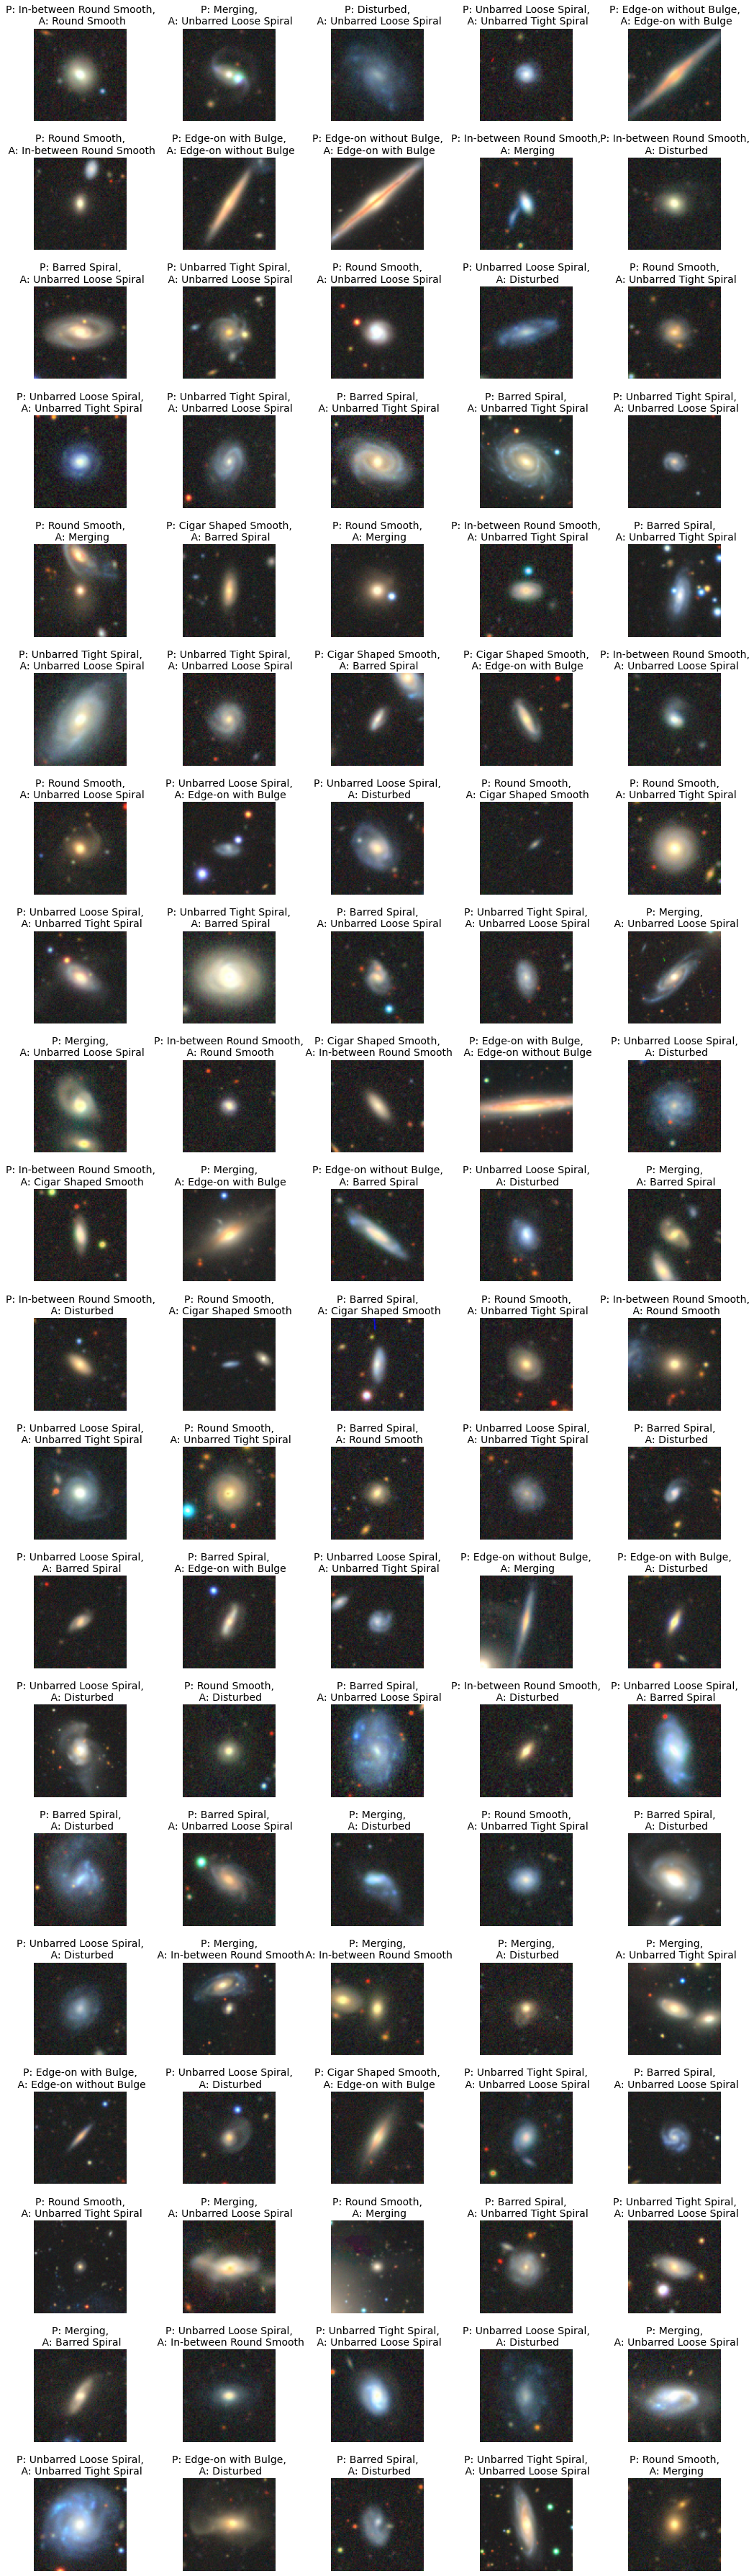

In [155]:
num=100
fig, axs = plt.subplots(int(num/5),5,figsize = (15,int((5*num)/10)))
for miss,ax,miss_pred, miss_actual in zip(misses[:num], axs.flatten(), missed_pred[:num], missed_actual[:num]):
    ax.imshow(miss)
    ax.set_title(f'P: {data.class_dict[miss_pred]},\n A: {data.class_dict[miss_actual]}',fontsize=14)
    ax.axis('off')
plt.tight_layout()

## Transfer Learning

In [20]:
base_model = keras.applications.VGG16(include_top=True, weights=None, input_shape=(64,64,3), classes=10, classifier_activation='softmax')

In [21]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [15]:
def add_new_last_layer(base_model, num_classes=10, drop_out=0.5):
    """Add last layer to the convnet
    Args:
    base_model: keras model excluding top
    num_classes: # of classes
    Returns:
    new keras model with last layer
    """
    # Get the output shape of the model's last layer
    x = layers.Flatten()(base_model.output)
    # Convert final MxNxC tensor output into a 1xC tensor where C is the # of channels.
    #x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(1024, activation='relu')(x) 
    x = keras.layers.Dropout(drop_out)(x)
    predictions = keras.layers.Dense(num_classes, activation='softmax')(x)

    model = keras.models.Model(inputs=base_model.input, outputs=predictions)
    return model

In [16]:
from tensorflow.keras.optimizers import RMSprop
# This will freeze the weights on all the layers except for our new dense layer
def transfer_setup(model, base_model):
    """Freeze all layers and compile the model"""
    for layer in base_model.layers:
       layer.trainable = False
    model.compile(optimizer=RMSprop(lr=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
train_model = add_new_last_layer(base_model)
transfer_setup(train_model, base_model)

/Users/jordyns/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [18]:
train_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [13]:
inception_base.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
xfer_aug = base_model.fit(datagen.flow(train_images, y_train, batch_size=32),
         validation_data=(test_images, y_test),
         steps_per_epoch=len(train_images) // 32, epochs=30)

Epoch 1/30
498/498 [==============================] - 740s 1s/step - loss: 2.2307 - accuracy: 0.1426 - val_loss: 2.2270 - val_accuracy: 0.1494
Epoch 2/30
498/498 [==============================] - 721s 1s/step - loss: 2.2215 - accuracy: 0.1466 - val_loss: 2.2261 - val_accuracy: 0.1483
Epoch 3/30
498/498 [==============================] - 721s 1s/step - loss: 2.2216 - accuracy: 0.1495 - val_loss: 2.2207 - val_accuracy: 0.1494
Epoch 4/30
357/498 [====================>.........] - ETA: 3:32 - loss: 2.2226 - accuracy: 0.1503

KeyboardInterrupt: 

Text(0.5, 0.98, 'VGG16')

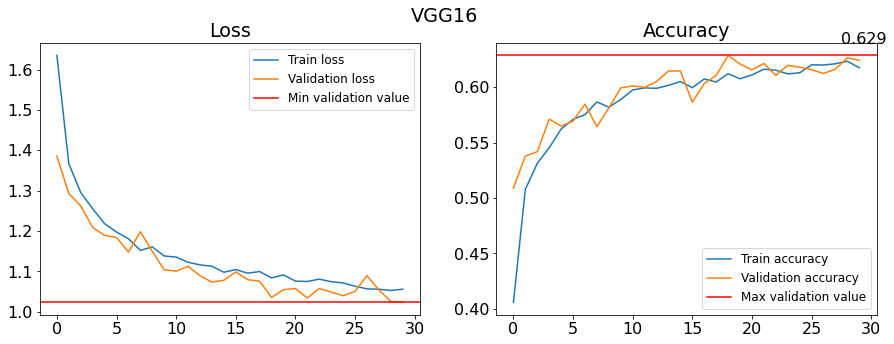

In [406]:
show_final_history(xfer_aug)
plt.suptitle('VGG16')

In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception_base = InceptionV3(input_shape = (88,88,3), include_top = True, weights=None, classes=10, classifier_activation='softmax')

In [23]:
incepx_model = add_new_last_layer(inception_base, drop_out=0)
transfer_setup(incepx_model, inception_base)

/Users/jordyns/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [20]:
incepx_aug = inception_base.fit(datagen.flow(train_images, y_train, batch_size=32),
         validation_data=(test_images, y_test),
         steps_per_epoch=len(train_images) // 32, epochs=10)

Epoch 1/10
498/498 [==============================] - 381s 765ms/step - loss: 0.9178 - accuracy: 0.7114 - val_loss: 2.3697 - val_accuracy: 0.3038
Epoch 2/10
498/498 [==============================] - 376s 753ms/step - loss: 0.9368 - accuracy: 0.6930 - val_loss: 0.9644 - val_accuracy: 0.6894
Epoch 3/10
498/498 [==============================] - 363s 728ms/step - loss: 0.8641 - accuracy: 0.7089 - val_loss: 0.8717 - val_accuracy: 0.6815
Epoch 4/10
137/498 [=======>......................] - ETA: 4:22 - loss: 0.7315 - accuracy: 0.7501

KeyboardInterrupt: 

In [30]:
inception_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 88, 88, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 43, 43, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 43, 43, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 43, 43, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Evaluating Saved CNNs

In [23]:
!ls saved_models

CNN1_20epochs_20210803.h5         CNN2_15epochs_88in20210803.h5
CNN2_15epochs_20210803.h5         CNN4_20epochs_64in20210804.h5
CNN2_15epochs_64in20210803.h5     CNN5_aug_50epochs_64in20210805.h5


In [50]:
models = []
for idx, model in enumerate(os.listdir('saved_models')):
    print(f'Model Name:{model}\n')
    models.append(keras.models.load_model(os.path.join('saved_models', model)))
    if models[idx].input_shape[1] == 88:
        models[idx].summary()
        models[idx].evaluate(lg_test_images, y_test)
    else: 
        models[idx].summary()
        models[idx].evaluate(test_images, y_test)
    print('*'*100)

Model Name:CNN1_20epochs_20210803.h5

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 16)        1216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        12832     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_5 (Dense) 

56/56 [==============================] - 1s 8ms/step - loss: 0.6905 - accuracy: 0.7734
****************************************************************************************************
Model Name:CNN5_aug_50epochs_64in20210805.h5

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_148 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_146 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_147 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 16, 16, 64)        18496     
_________________

In [140]:
accuracy_score(test_labels, y_pred)

0.8111612175873731

In [129]:
y_pred

array([7, 3, 2, ..., 7, 7, 3])

In [141]:
test_labels

array([7, 2, 2, ..., 7, 6, 3], dtype=uint8)

In [134]:
train_images, test_images = np.load('data/lg_train.npy'), np.load('data/lg_test.npy')
train_labels, test_labels = np.load('data/train_labels.npy'), np.load('data/test_labels.npy')